In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
news_filepath = '../data/experts_news.csv'
news = pd.read_csv(news_filepath)
news['datetime'] = pd.to_datetime(news.datetime, utc=True).dt.tz_convert('Europe/Kiev')
news['found_names_checked'] = news.found_names_checked_str.apply(lambda x: list(set(x.split('§'))) if pd.notna(x) else None)
news.info()

In [4]:
# список усіх імен з ідентифікаторами
experts_id = pd.read_csv('all_mentions_with_id.csv', index_col=0)
experts_id = experts_id[experts_id.index.notna()]

In [33]:
# списки доменів і категорій для стовпчиків
domains = sorted(list(news.domain.unique()))
domain_aliases = sorted(list(news.domain_alias.unique()))
categories = sorted(list(news.mycategory.unique()))
months = ['December', 'January', 'February']
all_columns = domains + categories + months
by_month_columns = domains + categories
by_category_columns = domains
by_category_with_alias = domain_aliases
all_columns_with_alias = domain_aliases + categories + months

In [55]:
# список імен на видалення
del_dict1 = json.load(open('del_list.txt'))
del_list_joined = list(del_dict1.keys())


In [36]:
# список імен з повними іменами і короткими описами 
endings_dict = json.load(open('names_with_endings.txt'))

In [37]:
cat_dict = {'Економіка': 'economics',
            'Суспільство':'society',
            'Коронавірус': 'covid',
            'Інциденти': 'incidents',
            'Політика': 'politics',
            'Спорт': 'sport', 
            'Життя/lifestyle':'lifestyle',
            'Світ':'world',
            'Погода':'weather',
            'Технології':'technologies',
            'Шоу-бізнес':'showbiz',
            'Війна/Донбас':'war',
            'Карантин':'quarantine',
            'Міжнародна політика':'inter_pol',
            'Інше':'other'}
top_categories = ['Економіка', 'Коронавірус', 'Інциденти', 'Політика', 'Світ']
top_str = '|'.join(top_categories)

In [38]:
# підрахунок імен в новинах, запис кількості у словник
def count_mentions(names_list, domain, category, news_date, columns_list, res_dict):
    if isinstance(names_list, list):
        for name in names_list:
            if name not in res_dict.keys():
                res_dict[name] = [0]*(len(columns_list)+1)
            res_dict[name][columns_list.index(domain)] += 1
            
            try:
                res_dict[name][columns_list.index(category)] += 1
            except:
                pass
            
            try:
                res_dict[name][columns_list.index(news_date.month_name())] += 1
            except:
                pass
            
            res_dict[name][-1] += 1
            

In [219]:
# поділ за категоріями і місяцями
cat_and_month_dict = {}
for m in months:
    year = news[news.datetime.dt.month_name()==m].datetime.dt.year.iloc[0]
    for c in categories:
        key = '_'.join([cat_dict[c], m[:3].lower(), str(year)])
        cat_and_month_dict[key] = {}
        news[(news.datetime.dt.month_name()==m)&(news.mycategory==c)].apply(lambda row: 
                      count_mentions(row.found_names_checked, 
                                     row.domain_alias,
                                     row.mycategory, 
                                    row.datetime, 
                                    by_category_with_alias,
                                    cat_and_month_dict[key]), axis=1)

In [209]:
# поділ за місяцями
news_months = news.datetime.dt.month.unique() 
by_month_dict = {}

for i in range(len(news_months)):
    year = news[news.datetime.dt.month==news_months[i]].datetime.dt.year.iloc[0]
    key = 'experts_all_'+months[i][:3].lower() + '_'+str(year)
    by_month_dict[key] = {}
    news[news.datetime.dt.month==news_months[i]].apply(lambda row: 
                      count_mentions(row.found_names_checked, 
                                     row.domain_alias,
                                     row.mycategory, 
                                    row.datetime, 
                                    by_category_with_alias,
                                     by_month_dict[key]), axis=1)

In [312]:
# поділ за категоріями
categories_dicts = {}

for cat in top_categories:
    categories_dicts[cat] = {}
    news[news.mycategory==cat].apply(lambda row: 
                      count_mentions(row.found_names_checked, 
                                     row.domain_alias,
                                     row.mycategory, 
                                     row.datetime, 
                                     by_category_with_alias,
                                     categories_dicts[cat]), axis=1)

In [39]:
# все разом - є кількості і за доменами, і за категоріями, і за місяцями
all_ment_dict = {}
news.apply(lambda row: count_mentions(row.found_names_checked, 
                                      row.domain_alias, 
                                      row.mycategory, 
                                      row.datetime, 
                                      all_columns_with_alias, 
                                      all_ment_dict), axis=1)


0         None
1         None
2         None
3         None
4         None
          ... 
446915    None
446916    None
446917    None
446918    None
446919    None
Length: 446920, dtype: object

In [56]:
# перетворити словник у датафрейм (звичайний або з дворівневими стовпчиками)
def from_dict_to_df(ment_dict, columns_dict, del_list, endings_dict, ids, multiindex):
    if multiindex:
        tuples = []
        for key, values in columns_dict.items():
            tuples += [(key, v) for v in values] 
        tuples += [('num', '')]

        columns = pd.MultiIndex.from_tuples(tuples)
        
    else:
        columns = columns_dict + ['num']

    res_df = pd.DataFrame.from_dict(ment_dict, orient='index', columns=columns)
    res_df['del_flag'] = False
    res_df['del_flag'] = res_df.del_flag.mask(res_df.index.isin(del_list), True)
    res_df = res_df.sort_values(by='num', ascending=False)
    
    res_df['expert'] = None
    
    for k,v in endings_dict.items():
        if k in res_df.index.values:
            res_df.loc[k, 'expert'] = v[0]
    
    res_df['expert_id'] = None
    res_df['expert_id'] = ids
        
    return res_df

In [286]:
# за категоріями і місяцями
cats_and_month_dfs = {}
for k, v in cat_and_month_dict.items():
    cats_and_month_dfs[k] = from_dict_to_df(v,
                                            domain_aliases,
#                                        {'domain': domains},
                                       del_list_joined,
                                       endings_dict,
                                       all_ments_df['id'], 
                                            False)

In [1]:
# за місяцями
by_month_dfs = {}
for k, v in by_month_dict.items():
    by_month_dfs[k] = from_dict_to_df(v,
                                      domain_aliases,
#                                        {'domain': domain_aliases},
                                       del_list_joined,
                                       endings_dict,
                                     all_ments_df['id'],
                                     False)

In [375]:
# за категоріями
by_cat_df = {}
for k, v in categories_dicts.items():
    by_cat_df[k] = from_dict_to_df(v,domain_aliases,
#                                        {'domain': domains},
                                       del_list_joined,
                                       endings_dict,
                                       experts_id['id'], 
                                            False)

In [57]:
# все разом 
all_ments_df = from_dict_to_df(all_ment_dict, 
                               {'domain': domain_aliases, 'category': categories, 'month': months},
                               del_list_joined,
                              endings_dict, experts_id['id'], True)

<AxesSubplot:xlabel='num', ylabel='expert'>

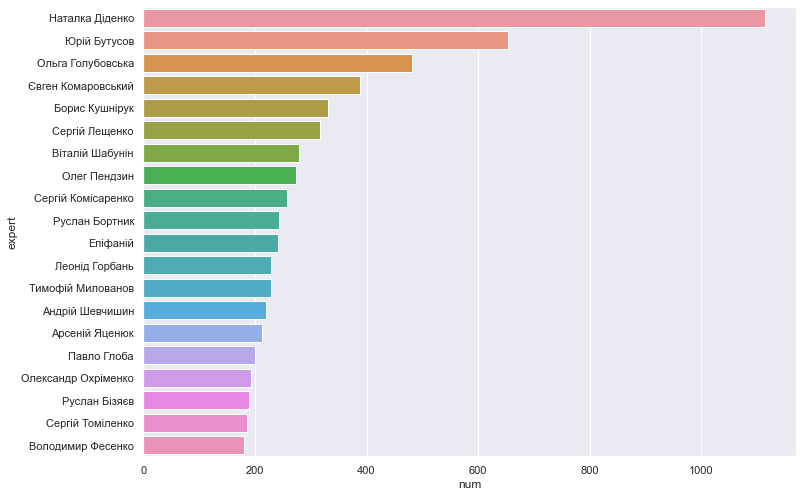

In [256]:
top_experts = all_ments_df[(~all_ments_df.del_flag)].head(20)

sns.barplot(x=top_experts.num, y=top_experts.expert, ci="sd")

In [267]:
experts_by_domains = all_ments_df[(~all_ments_df.del_flag)&(all_ments_df.num>50)]['domain'].T.copy()
for col in experts_by_domains.columns:
    experts_by_domains[col] = round(experts_by_domains[col]/experts_by_domains[col].sum()*100, 2)

In [140]:
experts_by_domains.iloc[:, :20]

,Наталк Діденк,Юр Бутус,Ольг Голубовськ,Євген Комаровськ,Борис Кушнірук,Серг Лещенк,Серг Гармаш,Вітал Шабунін,Олег Пендзин,Серг Комісаренк,Русла Бортник,Епіфан,Леонід Горбан,Тимоф Милован,Андр Шевчишин,Арсен Яценюк,Павел Глоб,Денис Казанськ,Олександр Охріменк,Русла Бизя
112.ua,0.09,0.31,0.83,0.26,0.00,0.32,1.92,0.72,0.36,1.56,1.23,0.83,0.44,0.88,0.00,2.36,0.0,0.00,1.56,0.00
24 канал,6.37,7.50,1.04,0.00,1.52,12.30,7.03,20.86,1.82,6.61,0.82,8.68,3.06,7.46,0.00,0.94,0.5,9.60,1.56,0.00
Gazeta.ua,6.37,3.52,4.78,2.32,0.91,0.95,1.60,4.68,0.73,2.72,0.00,2.89,10.04,5.26,0.00,0.94,0.0,1.52,3.65,0.00
LB.ua,0.09,2.91,0.83,0.00,0.00,0.63,3.19,1.08,0.00,0.00,0.00,1.24,0.00,1.32,0.00,0.00,0.0,1.52,0.00,0.00
LIGA.net,0.36,6.13,0.00,0.00,0.00,0.63,2.56,3.24,0.00,0.78,0.00,3.72,0.00,4.82,0.00,0.47,0.0,2.53,0.00,0.00
Politeka,3.59,0.46,3.74,2.84,17.27,0.63,0.32,0.00,6.57,2.33,9.47,0.41,6.11,0.88,4.57,2.36,11.5,1.01,5.73,8.42
ZIK,1.70,0.31,2.70,3.09,0.00,0.32,0.96,1.08,1.46,1.17,3.70,0.41,0.44,1.75,0.00,2.83,0.0,0.00,6.25,0.53
Zaxid.net,0.09,0.61,0.00,0.00,0.00,0.95,0.00,0.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.0,0.51,0.00,0.00
Znaj.ua,7.26,0.61,1.04,14.69,17.27,0.32,0.00,0.00,5.47,0.00,8.64,3.72,0.87,0.00,0.00,1.89,3.0,1.52,5.21,7.89
Інтерфакс-Україна,0.00,1.07,0.00,0.00,0.00,3.47,2.24,2.88,0.00,0.00,0.00,2.89,0.00,3.07,0.00,0.00,0.0,1.52,0.00,0.00


[Text(0, 0, 'Наталк Діденк'),
 Text(1, 0, 'Юр Бутус'),
 Text(2, 0, 'Ольг Голубовськ'),
 Text(3, 0, 'Євген Комаровськ'),
 Text(4, 0, 'Борис Кушнірук'),
 Text(5, 0, 'Серг Лещенк'),
 Text(6, 0, 'Серг Гармаш'),
 Text(7, 0, 'Вітал Шабунін'),
 Text(8, 0, 'Олег Пендзин'),
 Text(9, 0, 'Серг Комісаренк'),
 Text(10, 0, 'Русла Бортник'),
 Text(11, 0, 'Епіфан'),
 Text(12, 0, 'Леонід Горбан'),
 Text(13, 0, 'Тимоф Милован'),
 Text(14, 0, 'Андр Шевчишин'),
 Text(15, 0, 'Арсен Яценюк'),
 Text(16, 0, 'Павел Глоб'),
 Text(17, 0, 'Денис Казанськ'),
 Text(18, 0, 'Олександр Охріменк'),
 Text(19, 0, 'Русла Бизя')]

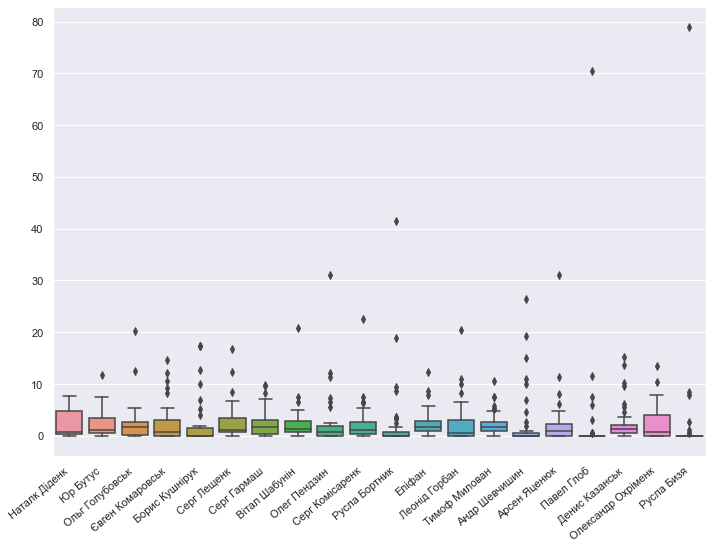

In [268]:
boxplot = sns.boxplot(data = experts_by_domains.iloc[:, 0:20])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")

In [11]:
# перегляд тексту новини з певним іменем
def check_news_by_mention(name, column_name, ind):
    pat = rf'§{name}§|^{name}§|§{name}$|^{name}$'
    print(news[news[column_name].str.contains(pat, na=False)].id.iloc[ind])
    print(news[news[column_name].str.contains(pat, na=False)].text.iloc[ind])

In [ ]:
check_news_by_mention('Наталк Діденк', 'found_names_checked_str', 95)

### Saving to file

In [3]:
news.columns

In [288]:
news[['title', 'text', 'link', 'domain', 'datetime', 'views', 'category',
       'language', 'id', 'mycategory', 'found_names_checked_str',
      'domain_alias']].to_csv(news_filepath, index=False)